 # Second Small Homework
 
 I took the neural netwrok straight from the website, the comments and everything are left in as is, the relevant parts are commented on in english!

In [1]:
# A notebook alapú megjelenítés aktiválása
%matplotlib inline
import matplotlib.pyplot as plt # Pylab grafikus megjelenítocsomag importálása

import numpy as np
from sklearn import preprocessing
import copy

In [2]:
def activation(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)


In [33]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
            
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        
        # New array for storing the data for momentum
        self._previousWeightDelta = []
        
        # HF2 start momentum in __init__
        for i in range(n-1):
            self._previousWeightDelta.append(np.zeros((self.layers[i].size,self.layers[i+1].size)))
        
        # HF2 end momentum in __init__
        
        # Súlyok újrainicializálása
        self.reset()
        
        
    
    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    
    
    #HF2 header params: new params for momentum and the optimizations all having a default of 0 so we can work without them
    def propagate_backward(self, target, lrate=0.1, momentum = 0.0, l_1=0, l_2=0): 
        deltas = []
        # Hiba kiszámítása a kimeneti rétegen
        error = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)  
            
        # Calculating the weights, this is where the optimizations and momentum comes into play
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
            
            # HF2 start Momentum added to dw
            # Applying the calculated momentum to the delta weight
            dw += self._previousWeightDelta[i] * momentum
            # HF2 end Momentum added to dw
            
            # HF2 start  l1reg
            # l1regularization
            dw += -lrate * l_1 * np.sign(self.weights[i]) 
            # This was simply from the presentaion, other online sources confirm this.
            # HF2 end  l1reg

            # HF2 start l2reg
            # l2reg implementation 
            dw += -lrate * l_2 * self.weights[i]  
            
            # This was simply from the presentaion, other online sources confirm this.
            # HF2 end l2reg
            
            # súlyok módosítása
            self.weights[i] += dw 

            # HF2 start momentum saving it in our momentum array
            
            # Saving this momentum for the next epoch which will accumalate over time.
            self._previousWeightDelta[i] = dw  
            # HF2 end momentum saving it in our momentum array

        # Visszatérés a hibával
        return (error**2).sum()

In [34]:
# updated function header to work with momentum and l1 and l2 regularization
def learn(network, X, Y, valid_split=0.2, test_split=0.1, epochs=20, lrate=0.1, momentum = 0.0, l_1=0, l_2=0):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate,momentum, l_1, l_2)
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]
        print("Test error: {}".format(test_err))
        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

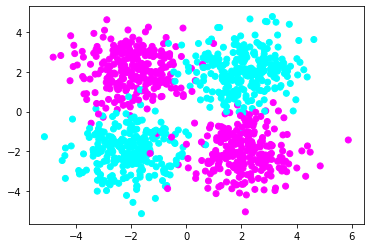

In [6]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

0 epoch, train_err: 0.2550, valid_err: 0.2506
1 epoch, train_err: 0.2506, valid_err: 0.2496
2 epoch, train_err: 0.2494, valid_err: 0.2485
3 epoch, train_err: 0.2475, valid_err: 0.2465
4 epoch, train_err: 0.2444, valid_err: 0.2429
5 epoch, train_err: 0.2387, valid_err: 0.2361
6 epoch, train_err: 0.2288, valid_err: 0.2246
7 epoch, train_err: 0.2136, valid_err: 0.2075
8 epoch, train_err: 0.1933, valid_err: 0.1856
9 epoch, train_err: 0.1693, valid_err: 0.1602
10 epoch, train_err: 0.1437, valid_err: 0.1352
11 epoch, train_err: 0.1215, valid_err: 0.1153
12 epoch, train_err: 0.1050, valid_err: 0.1008
13 epoch, train_err: 0.0931, valid_err: 0.0901
14 epoch, train_err: 0.0843, valid_err: 0.0821
15 epoch, train_err: 0.0776, valid_err: 0.0758
16 epoch, train_err: 0.0725, valid_err: 0.0709
17 epoch, train_err: 0.0683, valid_err: 0.0668
18 epoch, train_err: 0.0648, valid_err: 0.0634
19 epoch, train_err: 0.0618, valid_err: 0.0604

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.08  (elvart eredmeny

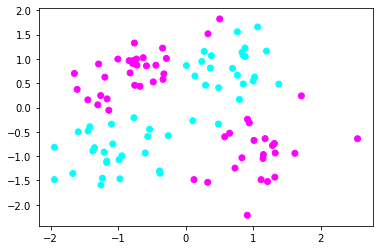

In [7]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess
network.reset()
#This one is so we have a baseline so we can see how well the added features help the network
learn(network, X, Y, epochs=20)

0 epoch, train_err: 0.2394, valid_err: 0.1681
1 epoch, train_err: 0.0807, valid_err: 0.0408
2 epoch, train_err: 0.0390, valid_err: 0.0357
3 epoch, train_err: 0.0346, valid_err: 0.0358
4 epoch, train_err: 0.0331, valid_err: 0.0360
5 epoch, train_err: 0.0322, valid_err: 0.0361
6 epoch, train_err: 0.0317, valid_err: 0.0362
7 epoch, train_err: 0.0313, valid_err: 0.0363
8 epoch, train_err: 0.0310, valid_err: 0.0364
9 epoch, train_err: 0.0308, valid_err: 0.0365
10 epoch, train_err: 0.0306, valid_err: 0.0366
11 epoch, train_err: 0.0305, valid_err: 0.0367
12 epoch, train_err: 0.0304, valid_err: 0.0368
13 epoch, train_err: 0.0303, valid_err: 0.0369
14 epoch, train_err: 0.0303, valid_err: 0.0370
15 epoch, train_err: 0.0302, valid_err: 0.0371
16 epoch, train_err: 0.0302, valid_err: 0.0372
17 epoch, train_err: 0.0302, valid_err: 0.0373
18 epoch, train_err: 0.0301, valid_err: 0.0374
19 epoch, train_err: 0.0301, valid_err: 0.0374

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.00  (elvart eredmeny

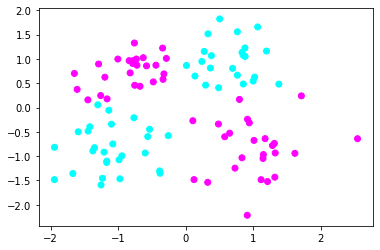

In [37]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with momentum
network.reset()
# A momentum of 0.932 looks seems to have be a number since it has the lowest TEST erorr after the network runs the test process
learn(network, X, Y,epochs=20,momentum=0.932)

0 epoch, train_err: 0.2550, valid_err: 0.2506
1 epoch, train_err: 0.2507, valid_err: 0.2497
2 epoch, train_err: 0.2494, valid_err: 0.2485
3 epoch, train_err: 0.2476, valid_err: 0.2466
4 epoch, train_err: 0.2446, valid_err: 0.2431
5 epoch, train_err: 0.2391, valid_err: 0.2366
6 epoch, train_err: 0.2295, valid_err: 0.2254
7 epoch, train_err: 0.2146, valid_err: 0.2087
8 epoch, train_err: 0.1946, valid_err: 0.1869
9 epoch, train_err: 0.1706, valid_err: 0.1616
10 epoch, train_err: 0.1450, valid_err: 0.1365
11 epoch, train_err: 0.1227, valid_err: 0.1164
12 epoch, train_err: 0.1059, valid_err: 0.1016
13 epoch, train_err: 0.0938, valid_err: 0.0908
14 epoch, train_err: 0.0849, valid_err: 0.0827
15 epoch, train_err: 0.0782, valid_err: 0.0764
16 epoch, train_err: 0.0729, valid_err: 0.0714
17 epoch, train_err: 0.0687, valid_err: 0.0673
18 epoch, train_err: 0.0652, valid_err: 0.0639
19 epoch, train_err: 0.0622, valid_err: 0.0609

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.08  (elvart eredmeny

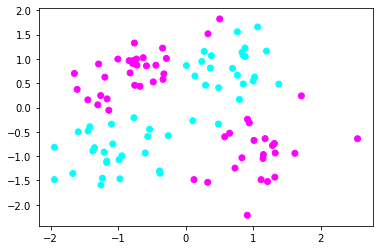

In [40]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with l1
network.reset()
learn(network, X, Y,epochs=20,l_1 = 0.00001)

0 epoch, train_err: 0.2550, valid_err: 0.2506
1 epoch, train_err: 0.2507, valid_err: 0.2497
2 epoch, train_err: 0.2495, valid_err: 0.2487
3 epoch, train_err: 0.2480, valid_err: 0.2470
4 epoch, train_err: 0.2454, valid_err: 0.2441
5 epoch, train_err: 0.2407, valid_err: 0.2386
6 epoch, train_err: 0.2326, valid_err: 0.2292
7 epoch, train_err: 0.2197, valid_err: 0.2145
8 epoch, train_err: 0.2017, valid_err: 0.1948
9 epoch, train_err: 0.1795, valid_err: 0.1712
10 epoch, train_err: 0.1548, valid_err: 0.1463
11 epoch, train_err: 0.1317, valid_err: 0.1252
12 epoch, train_err: 0.1138, valid_err: 0.1093
13 epoch, train_err: 0.1006, valid_err: 0.0976
14 epoch, train_err: 0.0910, valid_err: 0.0889
15 epoch, train_err: 0.0838, valid_err: 0.0822
16 epoch, train_err: 0.0782, valid_err: 0.0769
17 epoch, train_err: 0.0738, valid_err: 0.0727
18 epoch, train_err: 0.0701, valid_err: 0.0692
19 epoch, train_err: 0.0671, valid_err: 0.0662

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.10  (elvart eredmeny

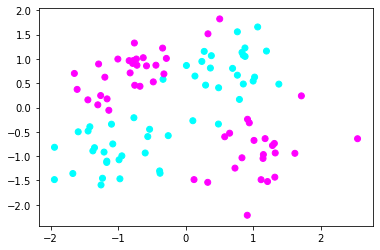

In [42]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with l2
network.reset()
learn(network, X, Y,epochs=20,l_2=0.0001)

0 epoch, train_err: 0.2402, valid_err: 0.1703
1 epoch, train_err: 0.0816, valid_err: 0.0409
2 epoch, train_err: 0.0389, valid_err: 0.0359
3 epoch, train_err: 0.0346, valid_err: 0.0358
4 epoch, train_err: 0.0331, valid_err: 0.0359
5 epoch, train_err: 0.0322, valid_err: 0.0360
6 epoch, train_err: 0.0317, valid_err: 0.0361
7 epoch, train_err: 0.0313, valid_err: 0.0362
8 epoch, train_err: 0.0310, valid_err: 0.0363
9 epoch, train_err: 0.0307, valid_err: 0.0364
10 epoch, train_err: 0.0306, valid_err: 0.0365
11 epoch, train_err: 0.0304, valid_err: 0.0366
12 epoch, train_err: 0.0303, valid_err: 0.0367
13 epoch, train_err: 0.0303, valid_err: 0.0368
14 epoch, train_err: 0.0302, valid_err: 0.0369
15 epoch, train_err: 0.0301, valid_err: 0.0369
16 epoch, train_err: 0.0301, valid_err: 0.0370
17 epoch, train_err: 0.0301, valid_err: 0.0371
18 epoch, train_err: 0.0301, valid_err: 0.0372
19 epoch, train_err: 0.0301, valid_err: 0.0373

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.00  (elvart eredmeny

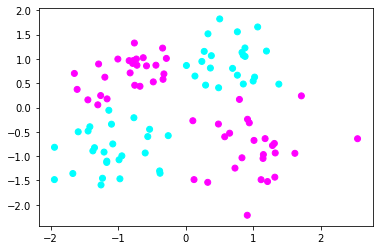

In [43]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with l1 and momentum
network.reset()
learn(network, X, Y,epochs=20,momentum=0.932, l_1 = 0.00001)

0 epoch, train_err: 0.2394, valid_err: 0.1681
1 epoch, train_err: 0.0807, valid_err: 0.0408
2 epoch, train_err: 0.0390, valid_err: 0.0357
3 epoch, train_err: 0.0346, valid_err: 0.0358
4 epoch, train_err: 0.0331, valid_err: 0.0360
5 epoch, train_err: 0.0322, valid_err: 0.0361
6 epoch, train_err: 0.0317, valid_err: 0.0362
7 epoch, train_err: 0.0313, valid_err: 0.0363
8 epoch, train_err: 0.0310, valid_err: 0.0364
9 epoch, train_err: 0.0308, valid_err: 0.0365
10 epoch, train_err: 0.0306, valid_err: 0.0366
11 epoch, train_err: 0.0305, valid_err: 0.0367
12 epoch, train_err: 0.0304, valid_err: 0.0368
13 epoch, train_err: 0.0303, valid_err: 0.0369
14 epoch, train_err: 0.0303, valid_err: 0.0370
15 epoch, train_err: 0.0302, valid_err: 0.0371
16 epoch, train_err: 0.0302, valid_err: 0.0372
17 epoch, train_err: 0.0302, valid_err: 0.0373
18 epoch, train_err: 0.0301, valid_err: 0.0374
19 epoch, train_err: 0.0301, valid_err: 0.0374

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.00  (elvart eredmeny

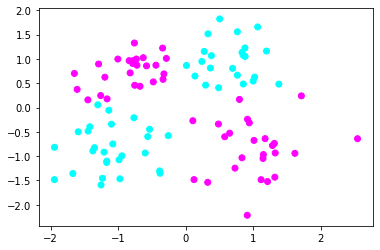

In [28]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with l2 and momentum
network.reset()
learn(network, X, Y,epochs=20,momentum=0.932, l_2 = 0.0001)

0 epoch, train_err: 0.2511, valid_err: 0.2058
1 epoch, train_err: 0.1116, valid_err: 0.0483
2 epoch, train_err: 0.0427, valid_err: 0.0395
3 epoch, train_err: 0.0377, valid_err: 0.0383
4 epoch, train_err: 0.0363, valid_err: 0.0380
5 epoch, train_err: 0.0357, valid_err: 0.0380
6 epoch, train_err: 0.0354, valid_err: 0.0380
7 epoch, train_err: 0.0353, valid_err: 0.0380
8 epoch, train_err: 0.0352, valid_err: 0.0380
9 epoch, train_err: 0.0352, valid_err: 0.0380
10 epoch, train_err: 0.0351, valid_err: 0.0380
11 epoch, train_err: 0.0351, valid_err: 0.0380
12 epoch, train_err: 0.0351, valid_err: 0.0380
13 epoch, train_err: 0.0351, valid_err: 0.0380
14 epoch, train_err: 0.0351, valid_err: 0.0380
15 epoch, train_err: 0.0351, valid_err: 0.0380
16 epoch, train_err: 0.0351, valid_err: 0.0380
17 epoch, train_err: 0.0351, valid_err: 0.0380
18 epoch, train_err: 0.0351, valid_err: 0.0380
19 epoch, train_err: 0.0351, valid_err: 0.0380

--- TESZTELÉS ---

0 [-1.25391297 -1.59160248] 0.02  (elvart eredmeny

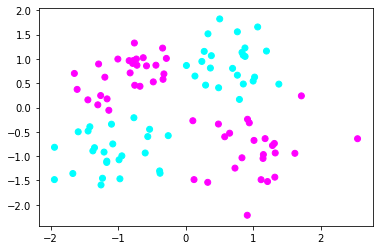

In [45]:
# Creation of the artificial neural network with 2 input, 10 hidden, and 1 output neurons.
network = MLP(2,5,1)
# Starting the learning/testing proccess with everything
network.reset()
learn(network, X, Y,epochs=20,momentum=0.932, l_1 = 0.0001, l_2 = 0.0001)

# Conclusion:
The momentum parameter was easy to implement and it was easy to set it to a value which visibly helped the network achieve a lower test error. The regularizations were a lot harder to make work in practice.

## Sources:

### Network taken from lessons

### Momentum:
Youtube: https://www.youtube.com/watch?v=v8be6yPsl2s

Article: https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx

Presentaion: http://smartlab.tmit.bme.hu/oktatas-deep-learning-eloadas?eloadas=3

### L1 and L2 optimization:

Article: https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036

https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261

Presentaion: http://smartlab.tmit.bme.hu/oktatas-deep-learning-eloadas?eloadas=3
